In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import math
import numpy as np

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.layers import Dense, Input, Dropout, Activation, Conv2D, MaxPooling2D, Lambda, Flatten, GlobalAveragePooling2D
from keras.layers.merge import concatenate

from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Flatten, Input, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model
from keras.models import Model, load_model
from keras.initializers import he_normal, glorot_normal

from keras.regularizers import l2
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16


import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
train_dir = 'data-ISBI-resized/train/'
validation_dir = 'data-ISBI-resized/validation/'
test_dir = 'data-ISBI-resized/test/'

extracted_features_dir = "extracted_features/"
model_name = "VGG16_MobileNet_Concatenate3_Adam"

In [4]:
batch_size = 32
img_height, img_width = 380, 380
input_shape = (img_height, img_width, 3)
epochs = 1000

top_model_path = os.path.join(extracted_features_dir, 'model_'+model_name+'_model.h5')
top_model_weights_path = os.path.join(extracted_features_dir, 'model_'+model_name+'_weights.h5')

In [5]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
#     validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
#     subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
#     subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 59170 images belonging to 2 classes.
Found 18384 images belonging to 2 classes.
Found 967 images belonging to 2 classes.


In [6]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("nb_test_samples:", nb_test_samples)

print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 59170
nb_validation_samples: 18384
nb_test_samples: 967

predict_size_train: 1850
predict_size_validation: 575
predict_size_test: 31

 num_classes: 2


In [8]:
basemodel1=VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
x1=basemodel1.get_layer('block5_pool').output
x1=GlobalAveragePooling2D()(x1)

basemodel2=MobileNet(weights=None,input_tensor = basemodel1.input, include_top=False, input_shape=input_shape)
x2 = basemodel2.output
x2 = GlobalAveragePooling2D()(x2)

merge = concatenate([x1, x2])
merge = Dropout(0.6)(merge)
preds = Dense(num_classes, activation='softmax')(merge)
model = Model(inputs=basemodel1.input,outputs=preds)

In [9]:
# bottleneck_final_model.summary()
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 conv1_pad
2 conv1
3 conv1_bn
4 conv1_relu
5 conv_dw_1
6 conv_dw_1_bn
7 conv_dw_1_relu
8 conv_pw_1
9 conv_pw_1_bn
10 conv_pw_1_relu
11 conv_pad_2
12 conv_dw_2
13 conv_dw_2_bn
14 conv_dw_2_relu
15 conv_pw_2
16 conv_pw_2_bn
17 conv_pw_2_relu
18 conv_dw_3
19 conv_dw_3_bn
20 conv_dw_3_relu
21 conv_pw_3
22 conv_pw_3_bn
23 conv_pw_3_relu
24 conv_pad_4
25 conv_dw_4
26 conv_dw_4_bn
27 conv_dw_4_relu
28 conv_pw_4
29 conv_pw_4_bn
30 conv_pw_4_relu
31 conv_dw_5
32 conv_dw_5_bn
33 conv_dw_5_relu
34 conv_pw_5
35 conv_pw_5_bn
36 conv_pw_5_relu
37 conv_pad_6
38 conv_dw_6
39 conv_dw_6_bn
40 conv_dw_6_relu
41 conv_pw_6
42 conv_pw_6_bn
43 conv_pw_6_relu
44 conv_dw_7
45 conv_dw_7_bn
46 conv_dw_7_relu
47 conv_pw_7
48 conv_pw_7_bn
49 conv_pw_7_relu
50 conv_dw_8
51 conv_dw_8_bn
52 conv_dw_8_relu
53 conv_pw_8
54 conv_pw_8_bn
55 conv_pw_8_relu
56 conv_dw_9
57 conv_dw_9_bn
58 conv_dw_9_relu
59 conv_pw_9
60 conv_pw_9_bn
61 conv_pw_9_relu
62 conv_dw_10
63 conv_dw_10_bn
64 conv_dw_10_relu
65 conv_pw_10

In [10]:
c1 = model.layers[74].output 
c1 = GlobalAveragePooling2D()(c1)       

c2 = model.layers[80].output
c2 = GlobalAveragePooling2D()(c2)       

c3 = model.layers[88].output
c3 = GlobalAveragePooling2D()(c3)       

c4 = model.layers[96].output
c4 = GlobalAveragePooling2D()(c4)

c5 = model.layers[103].output
c5 = GlobalAveragePooling2D()(c5)


con = concatenate([c1,c2,c3,c4,c5])

bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [11]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train, max_q_size=1, pickle_safe=False)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [12]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

In [13]:
bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [14]:
# import tensorflow as tf
# from keras.backend.tensorflow_backend import get_session
# from keras.backend.tensorflow_backend import clear_session
# from keras.backend.tensorflow_backend import set_session

# def reset_keras_tf_session():
#     """
#     this function clears the gpu memory and set the 
#     tf session to not use the whole gpu
#     """
#     sess = get_session()
#     clear_session()
#     sess.close()
#     sess = get_session()

#     config = tf.ConfigProto()
#     config.gpu_options.allow_growth = True
#     set_session(tf.Session(config=config))


# reset_keras_tf_session()

In [15]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [28]:
model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(num_classes, activation='softmax'))

adam_opt=Adam(lr = 0.001, beta_1=0.7, beta_2=0.999, amsgrad=True)
model.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

model.save_weights(top_model_weights_path)
model.save(top_model_path)

Train on 59170 samples, validate on 18384 samples
Epoch 1/1000
 - 8s - loss: 0.5264 - acc: 0.7584 - val_loss: 0.4921 - val_acc: 0.7765
Epoch 2/1000
 - 7s - loss: 0.5036 - acc: 0.7743 - val_loss: 0.4892 - val_acc: 0.7844
Epoch 3/1000
 - 7s - loss: 0.4971 - acc: 0.7770 - val_loss: 0.4818 - val_acc: 0.7858
Epoch 4/1000
 - 7s - loss: 0.4926 - acc: 0.7794 - val_loss: 0.4763 - val_acc: 0.7879
Epoch 5/1000
 - 7s - loss: 0.4890 - acc: 0.7796 - val_loss: 0.5002 - val_acc: 0.7662
Epoch 6/1000
 - 7s - loss: 0.4864 - acc: 0.7814 - val_loss: 0.4739 - val_acc: 0.7905
Epoch 7/1000
 - 7s - loss: 0.4873 - acc: 0.7799 - val_loss: 0.4702 - val_acc: 0.7943
Epoch 8/1000
 - 7s - loss: 0.4829 - acc: 0.7842 - val_loss: 0.4700 - val_acc: 0.7926
Epoch 9/1000
 - 7s - loss: 0.4812 - acc: 0.7844 - val_loss: 0.4695 - val_acc: 0.7955
Epoch 10/1000
 - 7s - loss: 0.4812 - acc: 0.7832 - val_loss: 0.4669 - val_acc: 0.7948
Epoch 11/1000
 - 7s - loss: 0.4786 - acc: 0.7860 - val_loss: 0.4649 - val_acc: 0.7956
Epoch 12/1000

Epoch 96/1000
 - 7s - loss: 0.4331 - acc: 0.8131 - val_loss: 0.4445 - val_acc: 0.8094
Epoch 97/1000
 - 7s - loss: 0.4347 - acc: 0.8111 - val_loss: 0.4340 - val_acc: 0.8146
Epoch 98/1000
 - 7s - loss: 0.4331 - acc: 0.8126 - val_loss: 0.4345 - val_acc: 0.8117
Epoch 99/1000
 - 7s - loss: 0.4338 - acc: 0.8116 - val_loss: 0.4323 - val_acc: 0.8155
Epoch 100/1000
 - 7s - loss: 0.4332 - acc: 0.8120 - val_loss: 0.4382 - val_acc: 0.8092
Epoch 101/1000
 - 7s - loss: 0.4338 - acc: 0.8117 - val_loss: 0.4322 - val_acc: 0.8143
Epoch 102/1000
 - 7s - loss: 0.4329 - acc: 0.8138 - val_loss: 0.4447 - val_acc: 0.8145
Epoch 103/1000
 - 7s - loss: 0.4370 - acc: 0.8099 - val_loss: 0.4319 - val_acc: 0.8151
Epoch 104/1000
 - 7s - loss: 0.4376 - acc: 0.8114 - val_loss: 0.4334 - val_acc: 0.8155
Epoch 105/1000
 - 7s - loss: 0.4370 - acc: 0.8106 - val_loss: 0.4391 - val_acc: 0.8129
Epoch 106/1000
 - 7s - loss: 0.4357 - acc: 0.8117 - val_loss: 0.4362 - val_acc: 0.8147
Epoch 107/1000
 - 7s - loss: 0.4345 - acc: 0.81

Epoch 191/1000
 - 8s - loss: 0.4246 - acc: 0.8186 - val_loss: 0.4337 - val_acc: 0.8154
Epoch 192/1000
 - 8s - loss: 0.4237 - acc: 0.8171 - val_loss: 0.4256 - val_acc: 0.8188
Epoch 193/1000
 - 8s - loss: 0.4249 - acc: 0.8177 - val_loss: 0.4261 - val_acc: 0.8197
Epoch 194/1000
 - 8s - loss: 0.4249 - acc: 0.8163 - val_loss: 0.4311 - val_acc: 0.8160
Epoch 195/1000
 - 8s - loss: 0.4215 - acc: 0.8171 - val_loss: 0.4305 - val_acc: 0.8147
Epoch 196/1000
 - 8s - loss: 0.4252 - acc: 0.8172 - val_loss: 0.4279 - val_acc: 0.8193
Epoch 197/1000
 - 8s - loss: 0.4243 - acc: 0.8193 - val_loss: 0.4272 - val_acc: 0.8191
Epoch 198/1000
 - 8s - loss: 0.4228 - acc: 0.8177 - val_loss: 0.4322 - val_acc: 0.8176
Epoch 199/1000
 - 8s - loss: 0.4260 - acc: 0.8168 - val_loss: 0.4259 - val_acc: 0.8174
Epoch 200/1000
 - 8s - loss: 0.4255 - acc: 0.8166 - val_loss: 0.4326 - val_acc: 0.8160
Epoch 201/1000
 - 8s - loss: 0.4248 - acc: 0.8167 - val_loss: 0.4461 - val_acc: 0.8102
Epoch 202/1000
 - 8s - loss: 0.4245 - acc: 

 - 7s - loss: 0.4161 - acc: 0.8222 - val_loss: 0.4240 - val_acc: 0.8211
Epoch 286/1000
 - 7s - loss: 0.4166 - acc: 0.8213 - val_loss: 0.4241 - val_acc: 0.8201
Epoch 287/1000
 - 7s - loss: 0.4157 - acc: 0.8233 - val_loss: 0.4258 - val_acc: 0.8196
Epoch 288/1000
 - 7s - loss: 0.4195 - acc: 0.8213 - val_loss: 0.4271 - val_acc: 0.8159
Epoch 289/1000
 - 7s - loss: 0.4184 - acc: 0.8207 - val_loss: 0.4248 - val_acc: 0.8199
Epoch 290/1000
 - 7s - loss: 0.4173 - acc: 0.8209 - val_loss: 0.4241 - val_acc: 0.8192
Epoch 291/1000
 - 7s - loss: 0.4172 - acc: 0.8201 - val_loss: 0.4256 - val_acc: 0.8203
Epoch 292/1000
 - 7s - loss: 0.4173 - acc: 0.8220 - val_loss: 0.4243 - val_acc: 0.8196
Epoch 293/1000
 - 7s - loss: 0.4150 - acc: 0.8228 - val_loss: 0.4310 - val_acc: 0.8145
Epoch 294/1000
 - 7s - loss: 0.4175 - acc: 0.8222 - val_loss: 0.4244 - val_acc: 0.8211
Epoch 295/1000
 - 7s - loss: 0.4162 - acc: 0.8215 - val_loss: 0.4341 - val_acc: 0.8134
Epoch 296/1000
 - 7s - loss: 0.4179 - acc: 0.8225 - val_lo

Epoch 380/1000
 - 7s - loss: 0.4113 - acc: 0.8257 - val_loss: 0.4225 - val_acc: 0.8216
Epoch 381/1000
 - 7s - loss: 0.4097 - acc: 0.8246 - val_loss: 0.4206 - val_acc: 0.8199
Epoch 382/1000
 - 7s - loss: 0.4093 - acc: 0.8269 - val_loss: 0.4207 - val_acc: 0.8207
Epoch 383/1000
 - 7s - loss: 0.4081 - acc: 0.8247 - val_loss: 0.4244 - val_acc: 0.8190
Epoch 384/1000
 - 7s - loss: 0.4100 - acc: 0.8240 - val_loss: 0.4273 - val_acc: 0.8206
Epoch 385/1000
 - 7s - loss: 0.4109 - acc: 0.8242 - val_loss: 0.4397 - val_acc: 0.8120
Epoch 386/1000
 - 7s - loss: 0.4255 - acc: 0.8159 - val_loss: 0.4191 - val_acc: 0.8232
Epoch 387/1000
 - 7s - loss: 0.4228 - acc: 0.8175 - val_loss: 0.4217 - val_acc: 0.8217
Epoch 388/1000
 - 7s - loss: 0.4244 - acc: 0.8162 - val_loss: 0.4244 - val_acc: 0.8200
Epoch 389/1000
 - 7s - loss: 0.4223 - acc: 0.8178 - val_loss: 0.4263 - val_acc: 0.8213
Epoch 390/1000
 - 7s - loss: 0.4177 - acc: 0.8213 - val_loss: 0.4251 - val_acc: 0.8196
Epoch 391/1000
 - 7s - loss: 0.4186 - acc: 

 - 7s - loss: 0.4099 - acc: 0.8239 - val_loss: 0.4222 - val_acc: 0.8192
Epoch 475/1000
 - 7s - loss: 0.4080 - acc: 0.8256 - val_loss: 0.4218 - val_acc: 0.8210
Epoch 476/1000
 - 7s - loss: 0.4114 - acc: 0.8246 - val_loss: 0.4259 - val_acc: 0.8167
Epoch 477/1000
 - 7s - loss: 0.4081 - acc: 0.8261 - val_loss: 0.4230 - val_acc: 0.8201
Epoch 478/1000
 - 7s - loss: 0.4072 - acc: 0.8259 - val_loss: 0.4290 - val_acc: 0.8172
Epoch 479/1000
 - 7s - loss: 0.4067 - acc: 0.8259 - val_loss: 0.4259 - val_acc: 0.8200
Epoch 480/1000
 - 7s - loss: 0.4075 - acc: 0.8243 - val_loss: 0.4266 - val_acc: 0.8216
Epoch 481/1000
 - 7s - loss: 0.4060 - acc: 0.8270 - val_loss: 0.4337 - val_acc: 0.8197
Epoch 482/1000
 - 7s - loss: 0.4058 - acc: 0.8259 - val_loss: 0.4247 - val_acc: 0.8199
Epoch 483/1000
 - 7s - loss: 0.4061 - acc: 0.8255 - val_loss: 0.4263 - val_acc: 0.8168
Epoch 484/1000
 - 7s - loss: 0.4064 - acc: 0.8269 - val_loss: 0.4220 - val_acc: 0.8213
Epoch 485/1000
 - 7s - loss: 0.4056 - acc: 0.8263 - val_lo

Epoch 569/1000
 - 7s - loss: 0.4070 - acc: 0.8271 - val_loss: 0.4222 - val_acc: 0.8221
Epoch 570/1000
 - 7s - loss: 0.4084 - acc: 0.8244 - val_loss: 0.4256 - val_acc: 0.8213
Epoch 571/1000
 - 7s - loss: 0.4083 - acc: 0.8247 - val_loss: 0.4253 - val_acc: 0.8205
Epoch 572/1000
 - 7s - loss: 0.4045 - acc: 0.8264 - val_loss: 0.4214 - val_acc: 0.8230
Epoch 573/1000
 - 7s - loss: 0.4057 - acc: 0.8265 - val_loss: 0.4287 - val_acc: 0.8151
Epoch 574/1000
 - 7s - loss: 0.4045 - acc: 0.8264 - val_loss: 0.4203 - val_acc: 0.8233
Epoch 575/1000
 - 7s - loss: 0.4052 - acc: 0.8271 - val_loss: 0.4360 - val_acc: 0.8164
Epoch 576/1000
 - 7s - loss: 0.4064 - acc: 0.8264 - val_loss: 0.4310 - val_acc: 0.8182
Epoch 577/1000
 - 7s - loss: 0.4042 - acc: 0.8281 - val_loss: 0.4212 - val_acc: 0.8223
Epoch 578/1000
 - 7s - loss: 0.4040 - acc: 0.8273 - val_loss: 0.4209 - val_acc: 0.8214
Epoch 579/1000
 - 7s - loss: 0.4026 - acc: 0.8278 - val_loss: 0.4182 - val_acc: 0.8234
Epoch 580/1000
 - 7s - loss: 0.4028 - acc: 

 - 7s - loss: 0.4125 - acc: 0.8199 - val_loss: 0.4238 - val_acc: 0.8217
Epoch 664/1000
 - 7s - loss: 0.4088 - acc: 0.8234 - val_loss: 0.4224 - val_acc: 0.8229
Epoch 665/1000
 - 7s - loss: 0.4073 - acc: 0.8233 - val_loss: 0.4192 - val_acc: 0.8231
Epoch 666/1000
 - 7s - loss: 0.4088 - acc: 0.8228 - val_loss: 0.4220 - val_acc: 0.8217
Epoch 667/1000
 - 7s - loss: 0.4097 - acc: 0.8255 - val_loss: 0.4241 - val_acc: 0.8207
Epoch 668/1000
 - 7s - loss: 0.4073 - acc: 0.8250 - val_loss: 0.4239 - val_acc: 0.8188
Epoch 669/1000
 - 7s - loss: 0.4045 - acc: 0.8267 - val_loss: 0.4203 - val_acc: 0.8214
Epoch 670/1000
 - 7s - loss: 0.4062 - acc: 0.8259 - val_loss: 0.4216 - val_acc: 0.8216
Epoch 671/1000
 - 7s - loss: 0.4079 - acc: 0.8251 - val_loss: 0.4247 - val_acc: 0.8194
Epoch 672/1000
 - 7s - loss: 0.4109 - acc: 0.8221 - val_loss: 0.4222 - val_acc: 0.8216
Epoch 673/1000
 - 7s - loss: 0.4069 - acc: 0.8255 - val_loss: 0.4453 - val_acc: 0.8120
Epoch 674/1000
 - 7s - loss: 0.4069 - acc: 0.8251 - val_lo

Epoch 758/1000
 - 7s - loss: 0.4097 - acc: 0.8212 - val_loss: 0.4344 - val_acc: 0.8202
Epoch 759/1000
 - 7s - loss: 0.4100 - acc: 0.8227 - val_loss: 0.4300 - val_acc: 0.8209
Epoch 760/1000
 - 7s - loss: 0.4098 - acc: 0.8226 - val_loss: 0.4212 - val_acc: 0.8209
Epoch 761/1000
 - 7s - loss: 0.4080 - acc: 0.8222 - val_loss: 0.4246 - val_acc: 0.8210
Epoch 762/1000
 - 7s - loss: 0.4077 - acc: 0.8236 - val_loss: 0.4304 - val_acc: 0.8182
Epoch 763/1000
 - 7s - loss: 0.4084 - acc: 0.8236 - val_loss: 0.4323 - val_acc: 0.8167
Epoch 764/1000
 - 7s - loss: 0.4066 - acc: 0.8255 - val_loss: 0.4285 - val_acc: 0.8190
Epoch 765/1000
 - 7s - loss: 0.4074 - acc: 0.8240 - val_loss: 0.4269 - val_acc: 0.8159
Epoch 766/1000
 - 7s - loss: 0.4055 - acc: 0.8239 - val_loss: 0.4257 - val_acc: 0.8198
Epoch 767/1000
 - 7s - loss: 0.4080 - acc: 0.8228 - val_loss: 0.4253 - val_acc: 0.8180
Epoch 768/1000
 - 7s - loss: 0.4069 - acc: 0.8246 - val_loss: 0.4300 - val_acc: 0.8220
Epoch 769/1000
 - 7s - loss: 0.4058 - acc: 

 - 7s - loss: 0.4065 - acc: 0.8254 - val_loss: 0.4245 - val_acc: 0.8224
Epoch 853/1000
 - 7s - loss: 0.4057 - acc: 0.8247 - val_loss: 0.4248 - val_acc: 0.8209
Epoch 854/1000
 - 7s - loss: 0.4079 - acc: 0.8247 - val_loss: 0.4231 - val_acc: 0.8234
Epoch 855/1000
 - 7s - loss: 0.4079 - acc: 0.8242 - val_loss: 0.4306 - val_acc: 0.8211
Epoch 856/1000
 - 7s - loss: 0.4044 - acc: 0.8253 - val_loss: 0.4210 - val_acc: 0.8201
Epoch 857/1000
 - 7s - loss: 0.4072 - acc: 0.8244 - val_loss: 0.4212 - val_acc: 0.8222
Epoch 858/1000
 - 7s - loss: 0.4032 - acc: 0.8258 - val_loss: 0.4302 - val_acc: 0.8178
Epoch 859/1000
 - 7s - loss: 0.4049 - acc: 0.8242 - val_loss: 0.4219 - val_acc: 0.8193
Epoch 860/1000
 - 7s - loss: 0.4033 - acc: 0.8265 - val_loss: 0.4227 - val_acc: 0.8213
Epoch 861/1000
 - 7s - loss: 0.4029 - acc: 0.8266 - val_loss: 0.4220 - val_acc: 0.8210
Epoch 862/1000
 - 7s - loss: 0.4021 - acc: 0.8264 - val_loss: 0.4751 - val_acc: 0.8017
Epoch 863/1000
 - 7s - loss: 0.4132 - acc: 0.8195 - val_lo

Epoch 947/1000
 - 7s - loss: 0.4001 - acc: 0.8277 - val_loss: 0.4223 - val_acc: 0.8229
Epoch 948/1000
 - 7s - loss: 0.4047 - acc: 0.8265 - val_loss: 0.4288 - val_acc: 0.8197
Epoch 949/1000
 - 7s - loss: 0.4098 - acc: 0.8244 - val_loss: 0.4215 - val_acc: 0.8198
Epoch 950/1000
 - 7s - loss: 0.4042 - acc: 0.8263 - val_loss: 0.4219 - val_acc: 0.8245
Epoch 951/1000
 - 7s - loss: 0.4040 - acc: 0.8264 - val_loss: 0.4238 - val_acc: 0.8239
Epoch 952/1000
 - 7s - loss: 0.4050 - acc: 0.8253 - val_loss: 0.4204 - val_acc: 0.8218
Epoch 953/1000
 - 7s - loss: 0.4058 - acc: 0.8269 - val_loss: 0.4302 - val_acc: 0.8126
Epoch 954/1000
 - 7s - loss: 0.4063 - acc: 0.8264 - val_loss: 0.4301 - val_acc: 0.8166
Epoch 955/1000
 - 7s - loss: 0.4147 - acc: 0.8190 - val_loss: 0.4226 - val_acc: 0.8217
Epoch 956/1000
 - 7s - loss: 0.4106 - acc: 0.8222 - val_loss: 0.4215 - val_acc: 0.8227
Epoch 957/1000
 - 7s - loss: 0.4095 - acc: 0.8226 - val_loss: 0.4218 - val_acc: 0.8238
Epoch 958/1000
 - 7s - loss: 0.4069 - acc: 

In [29]:
(eval_loss, eval_accuracy) = model.evaluate(validation_data, validation_labels, batch_size= batch_size, verbose=1)

print("Validation Accuracy: {:.4f}%".format(eval_accuracy * 100))
print("Validation Loss: {}".format(eval_loss))

18384/18384 [==============================] - 1s 39us/step
Validation Accuracy: 82.1312%
Validation Loss: 0.42368302216106546


In [30]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.9617373319544984


Confusion Matrix
[[651   4]
 [ 33 279]]


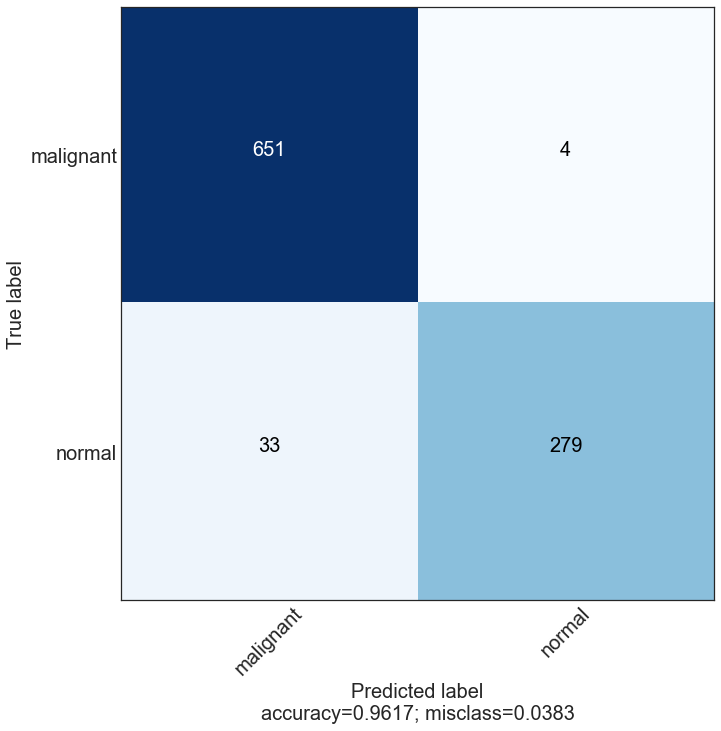

In [31]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [32]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[651   4]
 [ 33 279]]
              precision    recall  f1-score   support

      normal       0.95      0.99      0.97       655
   malignant       0.99      0.89      0.94       312

   micro avg       0.96      0.96      0.96       967
   macro avg       0.97      0.94      0.96       967
weighted avg       0.96      0.96      0.96       967



In [33]:
total=sum(sum(cm))

# accuracy = (cm[0,0]+cm[1,1]) / total
# print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  95.17543859649122
Specificity :  98.58657243816255


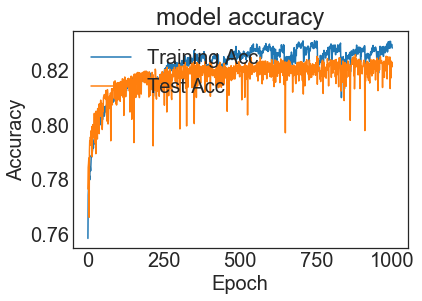

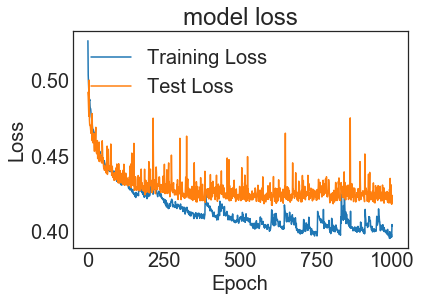

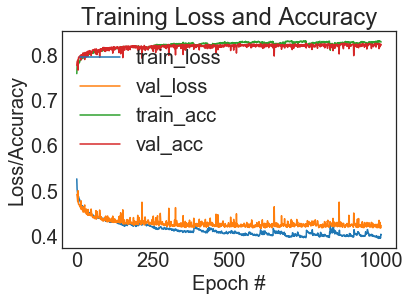

In [34]:
import seaborn
plt.style.use('seaborn-white')

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [35]:
y_pred_class = model.predict(test_data, verbose=1)

y_pred_class = [np.argmax(r) for r in y_pred_class]
test_y = [np.argmax(r) for r in test_labels]


from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, roc_curve

# Precision
print('Precision = ', precision_score(test_y, y_pred_class, average='weighted'))
# (None, 'micro', 'macro', 'weighted', 'samples')

# Recall
print('Recall = ', recall_score(test_y, y_pred_class, average='weighted'))

# f1_score
print('f1_score = ', f1_score(test_y, y_pred_class, average='weighted'))

967/967 [==============================] - 0s 42us/step
Precision =  0.9627603193527247
Recall =  0.9617373319544984
f1_score =  0.9612192259267028


In [36]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_test)

    truth = label_binarizer.transform(y_test)
    pred = label_binarizer.transform(y_pred)
    return roc_auc_score(truth, pred, average=average)
# roc_auc_score
print('roc_auc_score = ', multiclass_roc_auc_score(test_y, y_pred_class))

roc_auc_score =  0.9440619495008807


In [37]:
sample_count = test_generator.samples
print('Sample count: {}'.format(sample_count))

fnames = test_generator.filenames
ground_truth = test_generator.classes
label2index = test_generator.class_indices
# Getting the mapping from class index to class label
idx2label = dict((v, k) for k, v in label2index.items())
predictions = model.predict_classes(test_data)
prob = model.predict(test_data)
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors), sample_count))

Sample count: 967
No of errors = 37/967
